Original Train Shape: (8000, 7)
Resampled Train Shape: (15458, 7)

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1932
           1       0.36      0.69      0.47        68

    accuracy                           0.95      2000
   macro avg       0.67      0.82      0.72      2000
weighted avg       0.97      0.95      0.96      2000

ROC-AUC Score: 0.9553


/tmp/ipython-input-2089996631.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette="viridis")


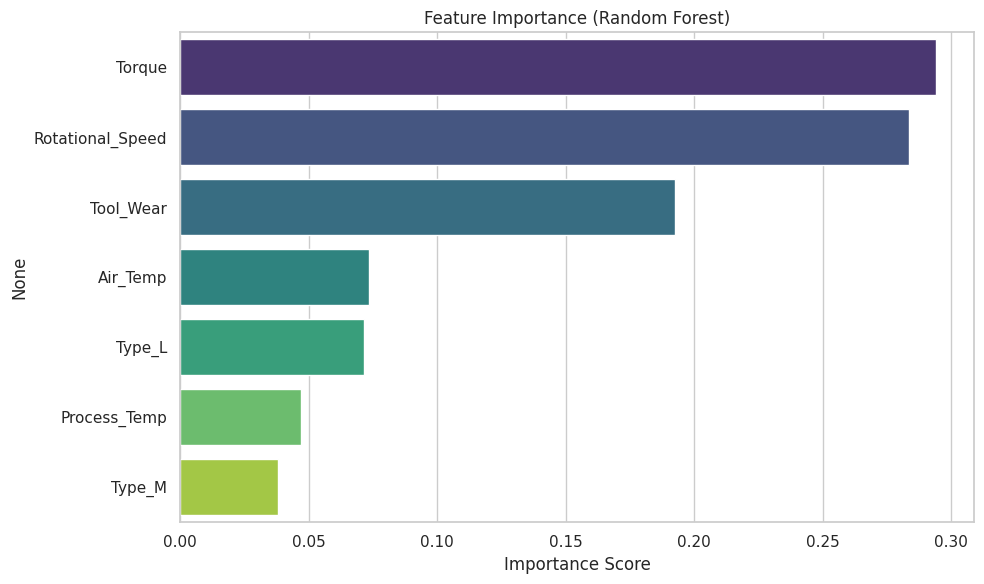

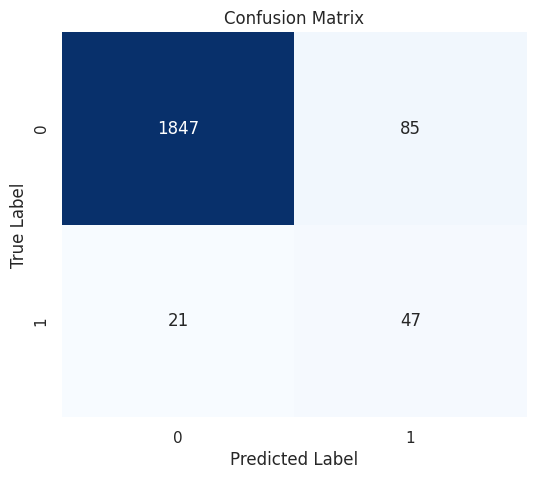

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Set plot style
sns.set(style="whitegrid")

# 1. Data Loading (UCI AI4I 2020 Dataset)
# Using real-world dataset instead of synthetic data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
try:
    df = pd.read_csv(url)
except Exception as e:
    print(f"Failed to download data: {e}")
    exit()

# 2. Data Preprocessing
# Rename columns for easier access
df.columns = ['UDI', 'Product_ID', 'Type', 'Air_Temp', 'Process_Temp',
              'Rotational_Speed', 'Torque', 'Tool_Wear', 'Machine_Failure',
              'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Drop ID columns (non-predictive) and specific failure type columns (to prevent data leakage)
# We only want to predict binary 'Machine_Failure' based on sensor readings
df_clean = df.drop(['UDI', 'Product_ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)

# Encode categorical 'Type' column (L/M/H quality variants)
df_clean = pd.get_dummies(df_clean, columns=['Type'], drop_first=True)

# Define X (Features) and y (Target)
X = df_clean.drop('Machine_Failure', axis=1)
y = df_clean['Machine_Failure']

# 3. Train/Test Split
# Stratify ensures the proportion of failures is maintained in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Handle Imbalance (SMOTE)
# Only apply SMOTE to training data to prevent testing on synthetic samples
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Original Train Shape: {X_train.shape}")
print(f"Resampled Train Shape: {X_train_res.shape}")

# 5. Model Training
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)

# 6. Evaluation
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 7. Visualizations

# Feature Importance
plt.figure(figsize=(10, 6))
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()